# BBC News Classification Kaggle Mini-Project

The objectives of this mini-project are:

- Perform an exploratory data analysis (EDA) procedure.
- Build and train an unsupervised learning model using Non-negative Matrix Factorisation (NMF).
- Build and train a supervised learning model.
- Compare the two models.

## Project setup

Import the required modules and load the datasets.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
from itertools import permutations
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


In [13]:
data_train = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
data_test = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")
sample_solution = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv")

### Inspection

#### Training data

In [14]:
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Using the data tab in the competition, we can see that all rows are valid, but only 1440 out 1490 values are unique in the Text column.

In addition, the Category column has a dtype of object without being categorised.

The next cell fixes these two issues.

In [15]:
data_train = data_train.drop_duplicates(subset = ["Text"])
data_train.Category = pd.Categorical(data_train.Category)

Next we check the ratios of the categories using a pie chart. From the chart below, it seems that the categories are well-balanced.

<Axes: >

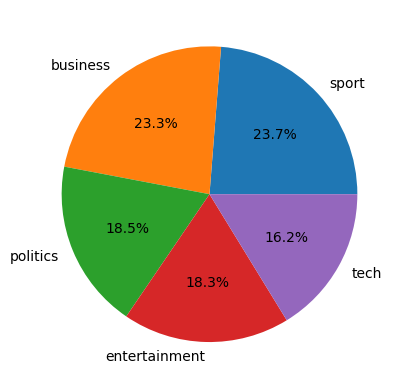

In [16]:
data_train.Category.value_counts().plot.pie(autopct='%1.1f%%', ylabel='')

#### Test data and provided sample solution

These have the same structure as the training data, except that one drops the Category column, while the solution drops the Text column.

In [17]:
print(data_test.info())
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [26]:
print(sample_solution.info())
sample_solution.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


## Preprocessing

Tf-idf converts a count matrix into a metric more suitable for our usecase by reducing the impact of highly-occuring words, making sure that words that occur less frequently overall, and are thus more likely to contribute to defining the topic of the article, are properly accounted for.

Before applying tf-idf, there are preprocessing tasks under consideration:

1. Convert to lower case.
1. Remove punctuation.
1. Remove stopwords.
1. Stemming/Lemmatisation.
1. Stripping extra white space.

Fortunately, all of these except of lemmatisation can be handled by TfidVectorizer easily, greatly simplifying the implementation. Note that when `analyzer == 'word'`, punctuation along with extra white space are automatically removed. Setting to lower case and removing stopwords can also be achieved by setting their respective parameters.

As for lemmatisation, it seems to be potentially useful according to [this stackexchange answer](https://stats.stackexchange.com/a/430776). However, [this paper](https://mimno.infosci.cornell.edu/papers/schofield_tacl_2016.pdf) suggests that the resulting complexity is not worth it, so I decided not to implement it afterall.

Instead, I will try replacing the numbers in the text with NUM using regex. This was much easier to implement, and would give some insight into whether the type of modifications done by stemming/lemmatisation actually help.

In [14]:
vectoriser = TfidfVectorizer(stop_words="english") # lowercase is True by default and analyzer==word.
train_vectorised = vectoriser.fit_transform(data_train.Text)
print(train_vectorised.shape)

(1440, 24456)


Now we will try to visualise the most common words. Notice that because we used the version with the numbers, some of them appear here. Between the numbers, it seems 000, along with specific years, are frequently occurring.

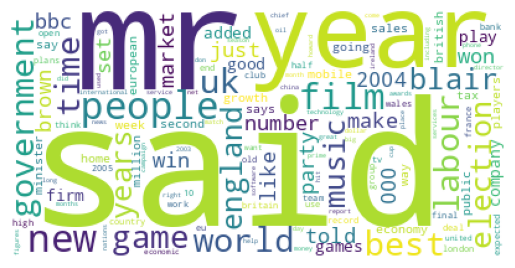

In [53]:
word_frequencies = pd.DataFrame(train_vectorised.toarray(), columns=vectoriser.get_feature_names_out()).T.sum(axis=1)
wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_frequencies.to_dict())
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Building and training the NMF model

In training the model, only the train data is used - the test dataset is not included. This allows the test dataset to do its job of measuring the accuracy of the model on untrained data. Nevertheless, it is very possible to train on the test data as well, as the label assignment can be done based on the `train` portion of the predictions.

Accuracy will be used as the performance metric as it is the one used by the competition.

The code below gives an accuracy of 90.8%. Surprisingly, when tested using data_test and submitted, it returned an even higher accuracy of 92.2% (V5).

In [44]:
nmf = NMF(n_components=5)
train_pred = nmf.fit_transform(train_vectorised).argmax(axis=1)

In [10]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels column from dataframe object.
    yp: label prediction output.
    Returns permuted label order and accuracy.
    Example output: ('business', 'politics', 'sport', 'entertainment', 'tech'), 0.74 .
    """
    y_true = ytdf
    best_acc = 0.
    for perm in permutations(ytdf.cat.categories):
        y_pred = [perm[i] for i in yp]
        accuracy = accuracy_score(y_true, y_pred)
        if accuracy > best_acc:
            best_acc = accuracy
            best_perm = perm
    return best_perm, best_acc

labels, acc = label_permute_compare(data_train.Category, train_pred)
print("Accuracy: %.1f%%" % (acc * 100))

Accuracy: 90.8%


### Try replacing the numbers with NUM

Here we see that reducing the complexity by generalising the numbers actually decreases the performance of the model.

In [11]:
data_train_without_nums = data_train["Text"].str.replace(r'\d+', 'NUM', regex=True)
vectorised_without_nums = TfidfVectorizer(stop_words="english").fit_transform(data_train_without_nums)
without_nums_pred = NMF(5).fit_transform(vectorised_without_nums).argmax(axis=1)
_, acc_without_num = label_permute_compare(data_train.Category, without_nums_pred)
print("Accuracy: %.1f%%" % (acc_without_num * 100))

Accuracy: 87.1%


### Changing the hyperparameters

In the previous models, parameters such as the maximum number of features and normalisation were ignored. We will now try out different combinations to try and improve the accuracy.

In [24]:
def gen_model(vectoriser):
    model = {"vectoriser": vectoriser}
    vectorised = vectoriser.fit_transform(data_train.Text)
    nmf = NMF(n_components=5)
    model["nmf"] = nmf
    y_pred = nmf.fit_transform(vectorised).argmax(axis=1)
    model["labels"], model["acc"] = label_permute_compare(data_train.Category, y_pred)
    return model

best_accuracy = 0.
for norm in ("l1", "l2", None):
    for max_features in (2000, 4000, 6000, 8000, None):
        model = gen_model(TfidfVectorizer(stop_words="english", norm=norm, max_features=max_features))
        print("norm=%s, max_features=%s, acc=%.1f%%" % (norm, max_features, model["acc"] * 100))
        if model["acc"] > best_accuracy:
            best_model = model
            best_accuracy = model["acc"]
print("Best model accuracy = %.1f%%" % (best_model["acc"] * 100))

norm=l1, max_features=2000, acc=89.2%
norm=l1, max_features=4000, acc=90.1%
norm=l1, max_features=6000, acc=90.0%
norm=l1, max_features=8000, acc=90.2%
norm=l1, max_features=None, acc=90.5%
norm=l2, max_features=2000, acc=89.9%
norm=l2, max_features=4000, acc=91.4%
norm=l2, max_features=6000, acc=91.2%
norm=l2, max_features=8000, acc=91.2%
norm=l2, max_features=None, acc=90.8%
norm=None, max_features=2000, acc=38.1%
norm=None, max_features=4000, acc=38.8%
norm=None, max_features=6000, acc=38.5%
norm=None, max_features=8000, acc=39.5%
norm=None, max_features=None, acc=37.0%
Best model accuracy = 91.4%


### Test on data_test

A model trained exclusively on the dataset is tested on the provided test dataset and submitted for evaluation. The best performing parameterised model, `best_model`, achieves a slightly higher accuracy on the test data as well (92.5%, V6 submission). On the other hand, the non-parametrised model (just l2 normalisation) had achieved 92.2% on the test dataset.

In [19]:
test_vectorised = best_model["vectoriser"].transform(data_test.Text)
test_pred = best_model["nmf"].transform(test_vectorised).argmax(axis=1)

In [1]:
sample_solution.Category = [best_model["labels"][x] for x in test_pred]
print("The order of solution df and test df is equivalent:", all(sample_solution.ArticleId == data_test.ArticleId))
print(sample_solution)
sample_solution.to_csv("submission.csv", index=False)

The order of solution df and test df is equivalent: True
     ArticleId       Category
0         1018          sport
1         1319           tech
2         1138          sport
3          459       business
4         1020          sport
..         ...            ...
730       1923       business
731        373  entertainment
732       1704           tech
733        206       business
734        471       politics

[735 rows x 2 columns]


## References

1. [How to apply a custom stemmer before passing the training corpus to TfidfVectorizer in sklearn?](https://stackoverflow.com/questions/48925747/how-to-apply-a-custom-stemmer-before-passing-the-training-corpus-to-tfidfvectori)
1. [How does adding/omitting lemmatization affect TF-IDF?](https://stats.stackexchange.com/a/430776)
1. [Comparing Apples to Apple: The Effects of Stemmers on Topic Models](https://mimno.infosci.cornell.edu/papers/schofield_tacl_2016.pdf)
1. [Sklearn: adding lemmatizer to CountVectorizer](https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer)
1. [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)